<a href="https://colab.research.google.com/github/dodofk/IM-Camp-ML-Course/blob/main/Lunar_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LunarLander-v2 DQN

## Install Packages

In [1]:
!nvidia-smi

Thu Dec 16 16:24:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt update 
!apt install python-opengl xvfb -y 
!pip install gym[box2d] pyvirtualdisplay tqdm wandb torch==1.10.0 --quiet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graph

In [3]:
# !wandb login
import wandb

wandb.init("lunar")

wandb: Currently logged in as: dodofk (use `wandb login --relogin` to force relogin)


## Import Package

In [4]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size= (1400, 900))
virtual_display.start()

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from IPython import display
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.autonotebook import tqdm

from collections import OrderedDict, namedtuple, deque
import random

### Setup Project Configuration



In [29]:
class cfg:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 64
    GAMMA = 0.99
    target_update = 6 
    lr = 1e-4
    weight_decay = 1e-4
    capacity = 10000
    tau = 1e-2
    episodes = 6000
    max_try = 2000

    eps_start = 1.0
    eps_end = 0.01
    eps_decay = 0.995
    
    save_path = "drive/MyDrive/MIULAB_DATASET/RL_Lunar/agent_new.pt"
    save_episode = 500

    observation_size = 8
    action_size = 4
    hidden_size = 64

### Setup Lunar Lander Enviroment

In [6]:
%%capture
import gym


env = gym.make('LunarLander-v2')

In [7]:
torch.__version__

'1.10.0+cu102'

In [8]:
def fix():
  torch.use_deterministic_algorithms(False)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

fix()

## LunarLander-v2 介紹

"LunarLander-v2" 是模擬登月小艇在著陸的過程，目的是讓登月小艇成功降落在兩個黃耆中間。

![](https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/LunarLander-v2/poster.jpg)






## 環境介紹


![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)


In [9]:
env.observation_space

Box(-inf, inf, (8,), float32)

說明其中有8維的向量是作為Agent判斷Action的observation

In [10]:
env.action_space

Discrete(4)

代表Agent每次可以選擇四種行動的其中一種

0: 什麼事情都不做

1: 點燃左側引擎

2: 點燃主引擎

3: 點燃右側引擎

In [11]:
initial_state = env.reset()
# 初始化
initial_state

array([ 9.34886921e-04,  1.41328394e+00,  9.46668833e-02,  1.05056696e-01,
       -1.07639120e-03, -2.14434583e-02,  0.00000000e+00,  0.00000000e+00],
      dtype=float32)

In [12]:
random_action = env.action_space.sample()
# 隨機產生的action
random_action

0

In [13]:
# 根據提供的Action(此處為Random Action)，來產生做完這個Action的環境狀態，獎賞，是否完成此任務，和其餘資訊等
observation, reward, done, info = env.step(random_action)

observation, reward, done, info

(array([ 0.00186949,  1.4150698 ,  0.09453909,  0.07937353, -0.00213599,
        -0.02119314,  0.        ,  0.        ], dtype=float32),
 1.5129009251826346,
 False,
 {})


Reward：



*   小艇墜地: -100
*   小艇一隻腳成功著陸: +10
*   點燃主引擎：-0.3
*   小艇最終完全靜止：+100
*   成功著陸：+100~140
---

原文：

> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame.







## 隨機運作

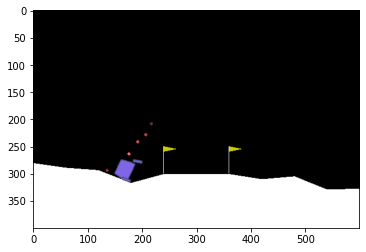

In [14]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False

while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)

    img.set_data(env.render(mode="rgb_array"))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Model and Agent

In [15]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

    def add(self, state, action ,reward, next_state, done):
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)

    def sample(self):
        experiences = random.sample(self.memory, k=cfg.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(cfg.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(cfg.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(cfg.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(cfg.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(cfg.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [16]:
class Q_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(cfg.observation_size, cfg.hidden_size)
        self.fc2 = nn.Linear(cfg.hidden_size, cfg.hidden_size)
        self.fc3 = nn.Linear(cfg.hidden_size, cfg.hidden_size)
        self.fc4 = nn.Linear(cfg.hidden_size, cfg.action_size)

    def forward(self, state):
        hid = F.relu(self.fc1(state))
        hid = F.relu(self.fc2(hid))
        hid = F.relu(self.fc3(hid))
        return self.fc4(hid)

## Deep Q-Network

[Original Paper Link](https://arxiv.org/abs/1509.06461)

[Reinforcement Learning 強化學習(DQN原理)](https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ml-note-reinforcement-learning-%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92-dqn-%E5%AF%A6%E4%BD%9Catari-game-7f9185f833b0)

In [17]:
class DQNAgent():
    def __init__(self):
        self.policy_net = Q_Network().to(cfg.device)
        self.target_net = Q_Network().to(cfg.device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayMemory(cfg.capacity)
        self.steps = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.steps = (self.steps + 1) % cfg.target_update
        if self.steps == 0:
            if len(self.memory) > cfg.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, cfg.GAMMA)

    def act(self, state, eps):
        state = torch.from_numpy(state).float().unsqueeze(0).to(cfg.device)
        self.policy_net.eval()
        with torch.no_grad():
            action_values = self.policy_net(state)

        self.policy_net.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else: 
            return random.choice(np.arange(4))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.policy_net(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.policy_net, self.target_net)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(cfg.tau * local_param.data + (1.0 - cfg.tau) * target_param.data)

    def save(self, path):
        Agent_Dict = {
            "network_policy": self.policy_net.state_dict(),
            "network_target": self.target_net.state_dict(),
            "optimizer": self.optimizer.state_dict(),
        }
        torch.save(Agent_Dict, path)


## Train

In [18]:
my_agent = DQNAgent()

In [19]:
total_rewards, final_rewards = [], []
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(cfg.episodes))

eps = cfg.eps_start
for index, episode in enumerate(prg_bar):
    state = env.reset()
    score = 0

    final_reward = 0
    for i in range(cfg.max_try):
        action = my_agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        my_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        
        if done or (i==cfg.max_try-1):
            final_reward = reward
            break;


    total_rewards.append(score)
    final_rewards.append(final_reward)
    eps = max(cfg.eps_end, eps * cfg.eps_decay)

    avg_total_reward = sum(total_rewards) / (len(total_rewards))
    avg_final_reward = sum(final_rewards) / (len(final_rewards))
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")


    wandb.log({"avg_final_reward": avg_final_reward, "total_reward": avg_total_reward})


  0%|          | 0/6000 [00:00<?, ?it/s]

In [30]:
torch.save(my_agent.policy_net.state_dict(), cfg.save_path)

## 訓練過程 

https://wandb.ai/dodofk/uncategorized/runs/2aqrrunk?workspace=user-dodofk

# Testing

240.87608901700318


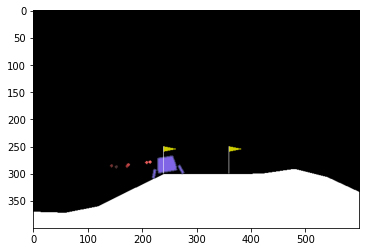

In [31]:
NUM_OF_TEST = 1 # Do not revise this !!!
test_agent = DQNAgent()
check_point = torch.load(cfg.save_path)
test_agent.policy_net.load_state_dict(check_point['network_policy'])
test_agent.policy_net.eval()

test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = test_agent.act(state,0)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


## 參考資料

https://github.com/sourcecode369/deep-reinforcement-learning

有興趣又有能力的可以聽以下課程：

https://www.youtube.com/watch?v=FgzM3zpZ55o&list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u